In [1]:
import sys
sys.path.insert(0, './scripts')

# now read in the new function
from helpers import get_data
from preprocessor import preprocessor

# and the other imports
%matplotlib inline
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [4]:
X, y = get_data('train')
X.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3291: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,parcelid,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [5]:
# use our preprocessor on the training data
p=preprocessor(cols_to_filter = ['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc', 
                                 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])

X = p.fit_transform(X)

In [6]:
X.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,propertycountylandusecode_73,propertycountylandusecode_8800,propertycountylandusecode_96,propertycountylandusecode_nan,fireplaceflag_True,fireplaceflag_nan,taxdelinquencyflag_Y,taxdelinquencyflag_nan,transactiondate_month,transactiondate_year
0,1.0,-1.0,-1.0,2.0,3.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
1,-1.0,-1.0,-1.0,3.5,4.0,-1.0,-1.0,3.5,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
2,1.0,-1.0,-1.0,3.0,2.0,-1.0,4.0,3.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
3,1.0,-1.0,-1.0,2.0,2.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
4,-1.0,-1.0,-1.0,2.5,4.0,-1.0,-1.0,2.5,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016


# Defining Success

Let's select our final model parameters based on the evaluation criterion used by the competition, Mean Absolute Error.

In [7]:
from helpers import mean_abs_error
import inspect
print(inspect.getsource(mean_abs_error))

def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))



# Parameter Tuning and Model Selection

For this part we're still only going to leverage the training data.

In [10]:
def select_params(X, y, max_estimators=1000, max_depth = 3, learning_rate=0.01):

    # in-time tune set
    X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
    
    # out-of-time tune set
    # train_index = X.transactiondate.argsort()[:int(len(X)*0.67)]
    # tune_index = X.transactiondate.argsort()[int(len(X)*0.67):]
    # X_train = X.iloc[train_index]
    # X_tune = X.iloc[tune_index]
    # y_train = y.iloc[train_index]
    # y_tune = y.iloc[tune_index]

    gbm = GradientBoostingRegressor(n_estimators = max_estimators, learning_rate=learning_rate, 
                                    max_depth=max_depth, loss='lad', subsample=0.5)

    gbm.fit(X_train, y_train)

    test_score = np.zeros((max_estimators,), dtype=np.float64)

    for i, y_pred in enumerate(gbm.staged_predict(X_tune)):
        test_score[i] = mean_abs_error(y_tune, y_pred)
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best MAE: {0}'.format(test_score.min()))
    print('baseline MAE: {0}'.format(mean_abs_error(y_tune, y_train.median())))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

# Tune Tree Depth


learning_rate and max_estimators are anticorrelated; the higher the learning rate the fewer trees are needed. Thus, cranking up the learning rate will make your models fit faster. This comes with a bit of an accuracy hit though, so one popular technique is to tune the tree depth with a higher learning rate and then tune the number of trees with a lower learning rate.

***** training for max depth = 2 *****
optimal number of trees: 703
best MAE: 0.06709060247329807
baseline MAE: 0.06803804369747765


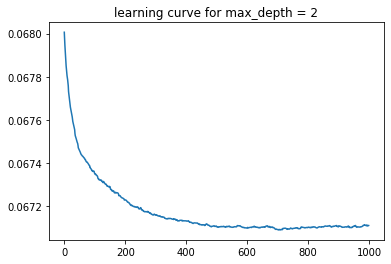

***** training for max depth = 3 *****
optimal number of trees: 428
best MAE: 0.06703643041748601
baseline MAE: 0.06803804369747765


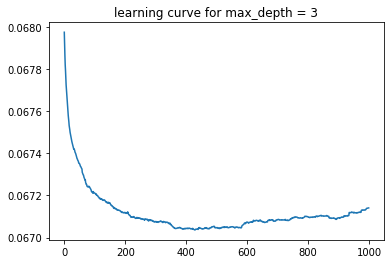

***** training for max depth = 4 *****
optimal number of trees: 134
best MAE: 0.06714158142647662
baseline MAE: 0.06803804369747765


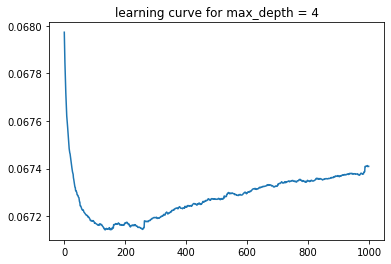

In [11]:
for depth in [2, 3, 4]:
    print('***** training for max depth = {0} *****'.format(depth))
    select_params(X, y, max_estimators=1000, max_depth=depth, learning_rate=0.1)

optimal number of trees: 494
best MAE: 0.06711803191972539
baseline MAE: 0.06803804369747765


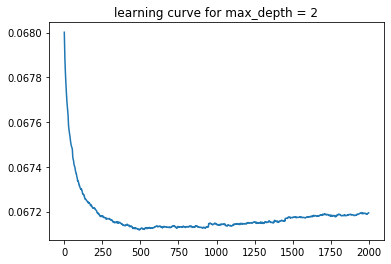

In [12]:
select_params(X, y, max_estimators=2000, max_depth=2, learning_rate=0.1)

# Final Parameters

So the parameters we've settled on are

n_estimators  = 1000
learning_rate = 0.1
max_depth     = 2
loss          = 'lad'
subsample     = 0.5
